In [ ]:
!pip install cftime
!pip install utils
!pip install netCDF4 
!pip install scipy
!pip install "xarray[io]"
!pip install kneed
!pip install importlib-metadata==4.13.0 
!pip install scikit-learn-extra

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [ ]:
#importing Libraries
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.metrics import v_measure_score
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

In [ ]:
path1 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock.nc')
path2 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock_v2.1.nc')
path3 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock_v3.1.1.nc')
path4 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock_v4.nc')
path5 = ('/content/drive/MyDrive/Multivariate Data Independent Study/New_ERA5_meteo_sfc_2021_daily.csv')
path6 = ('/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_hourly.nc')
path6 = ('/content/drive/MyDrive/Multivariate Data Independent Study/rdata_hourly.csv')
path7 = ('/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_hourly_smalldomain.nc')
path8 = ('/content/drive/MyDrive/Multivariate Data Independent Study/SST_ONLY_ERA5_meteo_sfc_2021_daily.csv')

#data1 = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
data1 = xr.open_dataset(path1) # To view time in datetime format
data2 = xr.open_dataset(path2)
data3 = xr.open_dataset(path3)
data4 = xr.open_dataset(path4)
data5 = pd.read_csv(path5)
data5=data5.drop(columns=['Unnamed: 0'])
data6 = pd.read_csv(path8)
data6=data6.drop(columns=['Unnamed: 0'])
#datat6 = pd.read_csv(path6)
#data7 = xr.open_dataset(path7)

In [ ]:
def transformdmock(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  sst_data_trans = pd.DataFrame()
  t2m_data_trans = pd.DataFrame()

  for i in range(0,dd.shape[0]):
    b=('sst'+'('+str(dd.lat[i])+','+str(dd.lon[i])+')')
    c=('t2m'+'('+str(dd.lat[i])+','+str(dd.lon[i])+')')

    sst_data_trans.loc[dd.time[i], b] = dd.sst[i]
    t2m_data_trans.loc[dd.time[i], c] = dd.t2m[i]

#Concating the variables 
  trans_concat = pd.concat([sst_data_trans, t2m_data_trans], axis=1)
#Scaling   
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled

In [ ]:
mock4= transformdmock(data4)


#RMSE

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds the values of dates in each cluster
def get_datewise_clusters(formed_clusters): # classification
  Dates_Cluster = {}
  for i in set(formed_clusters): # classification
    Dates_Cluster['Dates_Cluster'+str(i)] = trans_data.index[trans_data.Cluster == i].to_list()
  return Dates_Cluster

In [ ]:
# Non-normalized
# Function that creats a dictionary that holds all the clusters
def n_nor_get_clusters(input,formed_clusters): # classification
  com_arr = []
  Clusters = {}
  Dates_Cluster = get_datewise_clusters(formed_clusters)
  for i in set(formed_clusters):
    for j in Dates_Cluster['Dates_Cluster'+str(i)]:
      arr = np.array(input.isel(time=j).to_array()) # input is data
      com_arr.append(arr)
    Clusters['Cluster' + str(i)] = np.array(com_arr)
    com_arr = []
  return Clusters    

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

In [ ]:
# Non-normalized
def handle_missing_values(input):
  var_mean = {}
  for i in input.data_vars:
    if input[i].isnull().sum().item() > 0:
      print(i,'has null values')
      var_mean[str(i) + '_mean'] = input[i].mean().item()
      input[i] = input[i].fillna(var_mean[str(i) + '_mean'])
  return input

In [ ]:
# Non-normalized 
#Intra RMSE Calculation Function
def n_nor_intra_rmse(input,formed_clusters):
  sq_diff = []
  intra_rmse = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sq_diff)
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n))))
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

In [ ]:
# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers
def nor_get_clusters_and_centers(input,formed_clusters):
  Clusters = {}
  Cluster_Centers = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Clusters,Cluster_Centers

In [ ]:
# Normalized
# Intra RMSE Calculation Function
def nor_intra_rmse(input,formed_clusters):
  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sum(sq_diff))
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

In [ ]:
# RMSE Calculation
def RMSE(input,formed_clusters,frame,normalize=False):
  inter_rmse = []
  avg_cluster = {}

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_rmse(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(sum(sum(Sq_diff)))
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          n = len(avg_cluster['avg_cluster'+str(i)][0])
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  else:

  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(frame,formed_clusters)

    # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = nor_intra_rmse(frame,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(Sq_diff)
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())

  return mat

#K mediods Mock 4

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
def optimalk(data):
  cost =[]
  for i in range(1, 11):
      KM =KMedoids(n_clusters = i, metric='cosine',init='k-medoids++', max_iter = 500)
      KM.fit(data)
      
      # calculates squared error
      # for the clustered points
      cost.append(KM.inertia_)    
  
  # plot the cost against K values
  plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
  plt.xlabel("Value of K")
  plt.ylabel("Squared Error (Cost)")
   # clear the plot
  return plt.show()

In [ ]:
def kmedoids(X,data): # eps1 for epsilon , min for minimum samples, x is for data input
      kmedoids = KMedoids(n_clusters=X, metric='cosine',init='k-medoids++', ).fit(data)  # cosine distance calculation
     # core_samples_mask = np.zeros_like(kmedoids.labels_, dtype=bool)
      labels = kmedoids.labels_
      frame = pd.DataFrame(data)
      frame['Cluster'] = labels
      frame['Cluster'].value_counts()
      print("Estimated number of clusters: %d" % X)
      print(frame['Cluster'].value_counts())
      #print("Silhouette Coefficient: %0.3f" % silhouette_score(x, labels))
      return frame,labels

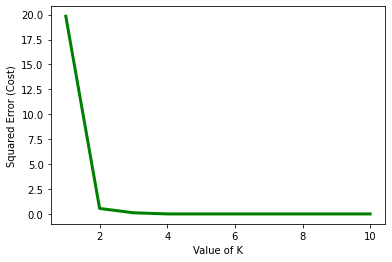

In [ ]:
optimalk(mock4)

In [ ]:
 frame1,label1= kmedoids(4,mock4)
 silhouette_score(mock4, label1, metric='cosine')

Estimated number of clusters: 4
3    5
0    5
1    5
2    5
Name: Cluster, dtype: int64


0.9999999999999698

In [ ]:
print("RMSE | Normalized with Mock")
final2 = RMSE(mock4,label1,frame1,True)
final2

RMSE | Normalized with Mock


,0,1,2,3
0,0.0,28.06,5.96,28.2
1,28.06,0.0,28.03,2.99
2,5.96,28.03,0.0,28.05
3,28.2,2.99,28.05,0.0


#Kmediods Real data

In [ ]:
#PCA
def pca1(data,n): # data is data to be input , n is the number of components 
  pca = PCA(n_components=n) 
  pca.fit(data)

  # Get pca scores
  pca_scores = pca.transform(data)

  # Convert pca_scores to a dataframe
  scores_df = pd.DataFrame(pca_scores)

  # Round to two decimals
  scores_df = scores_df.round(2)

  # Return scores
  return scores_df

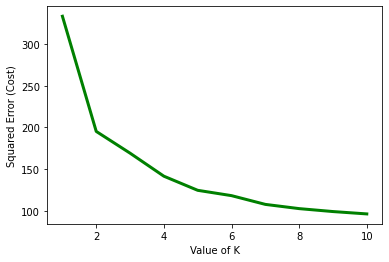

In [ ]:
optimalk(data5)

In [ ]:
frame2,label2= kmedoids(4,data5)
silhouette_score(data5, label2, metric='cosine')

Estimated number of clusters: 4
1    115
2    103
0     85
3     62
Name: Cluster, dtype: int64


0.2995701018574052

In [ ]:
print("RMSE | Normalized with Mock")
final2 = RMSE(data5, label2,frame2,True)
final2

RMSE | Normalized with Mock


,0,1,2,3
0,101.13,116.63,100.39,106.86
1,116.63,64.13,118.62,79.64
2,100.39,118.62,81.08,120.29
3,106.86,79.64,120.29,103.65


#PCA Realworld

In [ ]:
frame2,label2= kmedoids(4,pca1(data5,11))
silhouette_score(data5, label2, metric='cosine')

Estimated number of clusters: 4
3    123
2    103
0     83
1     56
Name: Cluster, dtype: int64


0.3230344419409978

In [ ]:
print("RMSE | Normalized with Mock")
final2 = RMSE(pca1(data5,11), label2,frame2,True)
final2

RMSE | Normalized with Mock


,0,1,2,3
0,101.61,114.99,100.56,114.76
1,114.99,99.18,99.47,95.75
2,100.56,99.47,72.54,123.63
3,114.76,95.75,123.63,62.24


#SST_ONLY

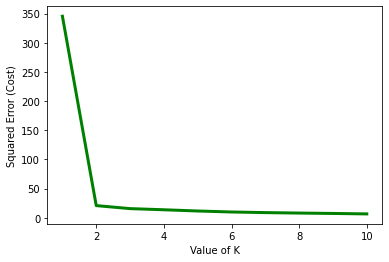

In [ ]:
optimalk(data6)

In [ ]:
frame4,label4= kmedoids(2,data6)
silhouette_score(data6, label4, metric='cosine')

Estimated number of clusters: 2
1    192
0    173
Name: Cluster, dtype: int64


0.9376464508758473

In [ ]:
print("RMSE | Normalized with SST only")
final2 = RMSE(data6, label4,frame4,True)
final2

RMSE | Normalized with SST only


,0,1
0,16.41,74.07
1,74.07,17.72


#PCA Only SST

In [ ]:
frame4,label4= kmedoids(2,pca1(data6,2))
silhouette_score(data6, label4, metric='cosine')

Estimated number of clusters: 2
0    191
1    174
Name: Cluster, dtype: int64


0.9374951934097201

In [ ]:
print("RMSE | Normalized with PCA SST only")
final2 = RMSE(pca1(data6,2), label4,frame4,True)
final2

RMSE | Normalized with PCA SST only


,0,1
0,16.41,74.07
1,74.07,17.72
